In [9]:
import sys
sys.path.append('../')

import os
import json
import qiskit
import pytket
import pytket.qasm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from phoenix import gates, Circuit, models
from phoenix.utils.operations import tensor_slots
from phoenix.utils.functions import infidelity
from scipy.stats import gmean

selected_molecules = ['LiH_frz_BK_sto3g', 'LiH_frz_JW_sto3g', 'NH_frz_BK_sto3g', 'NH_frz_JW_sto3g']

In [2]:
result_tket = pd.read_csv('tket_algo_err.csv')
result_phoenix = pd.read_csv('phoenix_algo_err.csv')

In [ ]:
result_tket['']

,LiH_frz_BK_sto3g,LiH_frz_JW_sto3g,NH_frz_BK_sto3g,NH_frz_JW_sto3g,amp
0,0.000111,0.000111,0.000538,0.000538,0.6
1,0.000349,0.000349,0.001672,0.001672,0.8
2,0.000845,0.000845,0.003996,0.003996,1.0
3,0.001729,0.001729,0.008071,0.008071,1.2
4,0.003156,0.003156,0.014489,0.014489,1.4
5,0.005290,0.005290,0.023825,0.023825,1.6
6,0.008306,0.008306,0.036588,0.036588,1.8


In [14]:
print(1 - gmean(result_phoenix['NH_frz_BK_sto3g'] / result_tket['NH_frz_BK_sto3g']), 
      1 - gmean(result_phoenix['NH_frz_JW_sto3g'] / result_tket['NH_frz_JW_sto3g']), 
      1 - gmean(result_phoenix['LiH_frz_BK_sto3g'] / result_tket['LiH_frz_BK_sto3g']), 
      1 - gmean(result_phoenix['LiH_frz_JW_sto3g'] / result_tket['LiH_frz_JW_sto3g']))

# 0.5699220535273521 0.4954662070239402 0.42721465298162853 0.341221315497548

0.5699220535273521 0.4954662070239402 0.42721465298162853 0.341221315497548


In [69]:
def ideal_evolution(json_fname):
    X = gates.X.data
    with open(json_fname, 'r') as f:
        data = json.load(f)
    ham = models.HamiltonianModel(data['paulis'], data['coeffs'])
    u = ham.unitary_evolution()
    u = u @ tensor_slots(reduce(np.kron, [X for _ in data['front_x_on']]), ham.num_qubits, data['front_x_on'])
    return u

def qiskit_O3_all2all(circ: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    from itertools import combinations
    for q0, q1 in combinations(range(circ.num_qubits), 2):
        circ.cx(q0, q1)
        circ.cx(q0, q1)
    circ = qiskit.transpile(circ, optimization_level=3, basis_gates=['u1', 'u2', 'u3', 'cx'])
    return circ

def qiskit_to_unitary(qc):
    import cirq
    import qiskit.qasm2
    from cirq.contrib.qasm_import import circuit_from_qasm
    circ = circuit_from_qasm(qiskit.qasm2.dumps(qc))
    return cirq.unitary(circ)

def tket_pass(circ) -> pytket.Circuit:
    from phoenix.synthesis.utils import unroll_u3

    # unroll U3
    circ = unroll_u3(circ).to_tket()

    # adaptive PauliSimp
    circ_tmp = circ.copy()
    best_depth_2q = circ.depth_2q()
    best_num_2q_gates = circ.n_2qb_gates()
    while True:
        pytket.passes.PauliSimp().apply(circ_tmp)
        if best_depth_2q > circ_tmp.depth_2q() and best_num_2q_gates > circ_tmp.n_2qb_gates():
            best_depth_2q = circ_tmp.depth_2q()
            best_num_2q_gates = circ_tmp.n_2qb_gates()
            circ = circ_tmp.copy()
        else:
            break

    # ! full peephole optimization: because when allow_swaps=True there might be fault synthesis results
    # pytket.passes.FullPeepholeOptimise(allow_swaps=False).apply(circ)

    return circ

def phoenix_pass(ham):
    # front_x_gates = [gates.X.on(q) for q in data['front_x_on']]
    circ = ham.phoenix_circuit()
    # circ.prepend(*front_x_gates)
    circ = qiskit_O3_all2all(circ.to_qiskit())
    return circ

In [46]:
json_fname = '../benchmarks/uccsd_json/{}.json'.format(selected_molecules[0])
qasm_fname = json_fname.replace('json', 'qasm')

In [105]:
json_fname = '../benchmarks/uccsd_json/{}.json'.format(mol)

with open(json_fname, 'r') as f:
    data = json.load(f)

In [70]:
infid_tket = []
infid_phoenix = []

# algo_err = {
#     '1e-2': {'tket': [], 'phoenix': []},
#     '1e-1': {'tket': [], 'phoenix': []},
#     '1e0': {'tket': [], 'phoenix': []},
#     '1e1': {'tket': [], 'phoenix': []},
#     '1e2': {'tket': [], 'phoenix': []},
#     # '1e3': {'tket': [], 'phoenix': []},
# }
# amplitudes = [1e-1, 1e0, 1e1, 1e2]
# amplitudes = [0.5, 1, 2, 3, 4, 5, 6]
amplitudes = [0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8]

tket_algo_err = {mol: [] for mol in selected_molecules}
phoenix_algo_err = {mol: [] for mol in selected_molecules}


for mol in selected_molecules:
    print()
    print('Molecule:', mol)
    json_fname = '../benchmarks/uccsd_json/{}.json'.format(mol)

    with open(json_fname, 'r') as f:
        data = json.load(f)

    
    for amp in amplitudes:
        ham = models.HamiltonianModel(data['paulis'], data['coeffs'])
        ham.coeffs *= amp
        u = ham.unitary_evolution()
        circ = ham.generate_circuit()

        circ_tket = tket_pass(circ)
        circ_phoenix = phoenix_pass(ham)

        tket_algo_err[mol].append(infidelity(circ_tket.get_unitary(), u))
        phoenix_algo_err[mol].append(infidelity(qiskit_to_unitary(circ_phoenix), u))

        print('{} Molecule: TKet {:.6f}, Phoenix {:.6f}'.format(amp, tket_algo_err[mol][-1], phoenix_algo_err[mol][-1]))


Molecule: LIH_frz_BK_sto3g


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.6 Molecule: TKet 0.000111, Phoenix 0.000063


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.8 Molecule: TKet 0.000349, Phoenix 0.000198


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1 Molecule: TKet 0.000845, Phoenix 0.000481


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.2 Molecule: TKet 0.001729, Phoenix 0.000989


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.4 Molecule: TKet 0.003156, Phoenix 0.001814


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.6 Molecule: TKet 0.005290, Phoenix 0.003058


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.8 Molecule: TKet 0.008306, Phoenix 0.004834

Molecule: LIH_frz_JW_sto3g


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.6 Molecule: TKet 0.000111, Phoenix 0.000073


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.8 Molecule: TKet 0.000349, Phoenix 0.000229


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1 Molecule: TKet 0.000845, Phoenix 0.000555


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.2 Molecule: TKet 0.001729, Phoenix 0.001138


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.4 Molecule: TKet 0.003156, Phoenix 0.002082


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.6 Molecule: TKet 0.005290, Phoenix 0.003499


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.8 Molecule: TKet 0.008306, Phoenix 0.005510

Molecule: NH_frz_BK_sto3g


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.6 Molecule: TKet 0.000538, Phoenix 0.000226


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.8 Molecule: TKet 0.001672, Phoenix 0.000706


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1 Molecule: TKet 0.003996, Phoenix 0.001699


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.2 Molecule: TKet 0.008071, Phoenix 0.003458


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.4 Molecule: TKet 0.014489, Phoenix 0.006270


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.6 Molecule: TKet 0.023825, Phoenix 0.010433


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.8 Molecule: TKet 0.036588, Phoenix 0.016247

Molecule: NH_frz_JW_sto3g


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.6 Molecule: TKet 0.000538, Phoenix 0.000270


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.8 Molecule: TKet 0.001672, Phoenix 0.000839


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1 Molecule: TKet 0.003996, Phoenix 0.002009


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.2 Molecule: TKet 0.008071, Phoenix 0.004067


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.4 Molecule: TKet 0.014489, Phoenix 0.007323


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.6 Molecule: TKet 0.023825, Phoenix 0.012089


/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1.8 Molecule: TKet 0.036588, Phoenix 0.018655


In [107]:
selected_molecules

['LiH_frz_BK_sto3g', 'LiH_frz_JW_sto3g', 'NH_frz_BK_sto3g', 'NH_frz_JW_sto3g']

In [109]:
# 5 Molecule: TKet 0.249304, Phoenix 0.185308

# result = pd.DataFrame({
#     'amp': amplitudes,
#     'tket': tkt_algo_err,
result_tket = pd.DataFrame(tket_algo_err)
result_phoenix = pd.DataFrame(phoenix_algo_err)
result_tket['amp'] = amplitudes
result_phoenix['amp'] = amplitudes
result_tket.to_csv('tket_algo_err.csv', index=False)
result_phoenix.to_csv('phoenix_algo_err.csv', index=False)

In [112]:
result_tket

,LiH_frz_BK_sto3g,LiH_frz_JW_sto3g,NH_frz_BK_sto3g,NH_frz_JW_sto3g,amp
0,0.000111,0.000111,0.000538,0.000538,0.6
1,0.000349,0.000349,0.001672,0.001672,0.8
2,0.000845,0.000845,0.003996,0.003996,1.0
3,0.001729,0.001729,0.008071,0.008071,1.2
4,0.003156,0.003156,0.014489,0.014489,1.4
5,0.005290,0.005290,0.023825,0.023825,1.6
6,0.008306,0.008306,0.036588,0.036588,1.8


In [113]:
result_phoenix

,LiH_frz_BK_sto3g,LiH_frz_JW_sto3g,NH_frz_BK_sto3g,NH_frz_JW_sto3g,amp
0,0.000063,0.000073,0.000226,0.000270,0.6
1,0.000198,0.000229,0.000706,0.000839,0.8
2,0.000481,0.000555,0.001699,0.002009,1.0
3,0.000989,0.001138,0.003458,0.004067,1.2
4,0.001814,0.002082,0.006270,0.007323,1.4
5,0.003058,0.003499,0.010433,0.012089,1.6
6,0.004834,0.005510,0.016247,0.018655,1.8


/var/folders/r5/1qhftv4d3_g432jmyr9vy6wc0000gn/T/ipykernel_62075/1666155516.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['x'] + [str(x) for x in amplitudes[1:]], fontsize=12)
/var/folders/r5/1qhftv4d3_g432jmyr9vy6wc0000gn/T/ipykernel_62075/1666155516.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['x'] + [str(x) for x in amplitudes[1:]], fontsize=12)


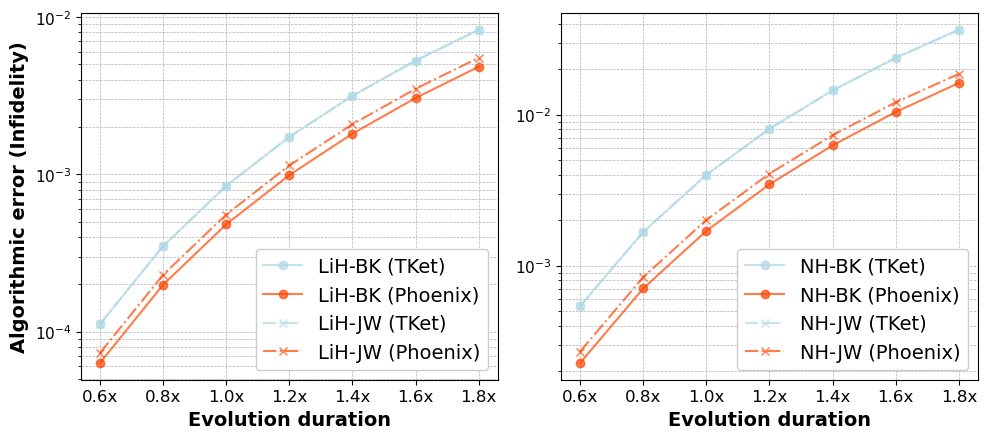

In [ ]:
plt.figure(figsize=(10, 4.5))


# LiH 
plt.subplot(1, 2, 1)
plt.plot(result_tket['amp'], result_tket['LiH_frz_BK_sto3g'], label='LiH-BK (TKet)', marker='o', color='lightblue', linestyle='-', alpha=0.7)
plt.plot(result_phoenix['amp'], result_phoenix['LiH_frz_BK_sto3g'], label='LiH-BK (Phoenix)', marker='o', color='#FF4500', linestyle='-', alpha=0.7)
plt.plot(result_tket['amp'], result_tket['LiH_frz_JW_sto3g'], label='LiH-JW (TKet)', marker='x', color='lightblue', linestyle='-.', alpha=0.7)
plt.plot(result_phoenix['amp'], result_phoenix['LiH_frz_JW_sto3g'], label='LiH-JW (Phoenix)', marker='x', color='#FF4500', linestyle='-.', alpha=0.7)

plt.xlabel('Evolution duration', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.ylabel('Algorithmic error (Infidelity)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, framealpha=1)
plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)

# let xtick to be 'x' to represent times
plt.gca().set_xticklabels(['x'] + [str(x) for x in amplitudes[1:]], fontsize=12)
def format_func(value, tick_number):
    return f'{value:.1f}x'
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# NH
plt.subplot(1, 2, 2)
plt.plot(result_tket['amp'], result_tket['NH_frz_BK_sto3g'], label='NH-BK (TKet)', marker='o', color='lightblue', linestyle='-', alpha=0.7)
plt.plot(result_phoenix['amp'], result_phoenix['NH_frz_BK_sto3g'], label='NH-BK (Phoenix)', marker='o', color='#FF4500', linestyle='-', alpha=0.7)
plt.plot(result_tket['amp'], result_tket['NH_frz_JW_sto3g'], label='NH-JW (TKet)', marker='x', color='lightblue', linestyle='-.', alpha=0.7)
plt.plot(result_phoenix['amp'], result_phoenix['NH_frz_JW_sto3g'], label='NH-JW (Phoenix)', marker='x', color='#FF4500', linestyle='-.', alpha=0.7)

plt.xlabel('Evolution duration', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)


# let xtick to be 'x' to represent times
plt.gca().set_xticklabels(['x'] + [str(x) for x in amplitudes[1:]], fontsize=12)
def format_func(value, tick_number):
    return f'{value:.1f}x'
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_func))

plt.yticks(fontsize=11)
# plt.ylabel('Algorithmic error (Infidelity)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, framealpha=1)
plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

# plt.savefig('./figures/algo_err.pdf')

plt.show()

In [ ]:
infid_tket

[0.0008445072381085827,
 0.0008445072381084717,
 0.003996423786951531,
 0.0039964237869505315]

In [42]:
infid_phoenix

[0.0004809289396006111,
 0.0005549586197597378,
 0.001698807365719146,
 0.0020086347776472335]

In [37]:
infidelity(qiskit_to_unitary(circ_phoenix), ideal_evolution(json_fname))

0.0004809289396006111

In [38]:
infidelity(circ_tket.get_unitary(), ideal_evolution(json_fname))

0.0008445072381085827

In [29]:
# for mol in selected_molecules:
#     ...

mol = selected_molecules[0]

with open('../benchmarks/uccsd_json/{}.json'.format(mol), 'r') as f:
    data = json.load(f)

ham = models.HamiltonianModel(data['paulis'], data['coeffs'])
front_x_gates = [gates.X.on(q) for q in data['front_x_on']]
circ_phoenix = ham.phoenix_circuit()
# circ_phoenix.prepend(*front_x_gates)
circ_phoenix = qiskit_O3_all2all(circ_phoenix.to_qiskit())

# circ_phoenix = qiskit.transpile(circ_phoenix.to_qiskit(), optimization_level=0, basis_gates=['u1', 'u2', 'u3', 'cx'])

# circ_phoenix = ham.reconfigure_and_generate_circuit()

/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/anan/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [23]:
infidelity(qiskit_to_unitary(circ_phoenix.to_qiskit()), ham.unitary_evolution())


0.0007028982917370863

In [30]:
infidelity(qiskit_to_unitary(circ_phoenix), ham.unitary_evolution())

0.00048092893960072214